In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
#import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import numpy as np
np.set_printoptions(suppress=True)


from numba import jit
from data.data import enhance_contrast, add_counting_noise, forward_model
from data import priors
from deep_bayes import theta as thetaed
from deep_bayes.models import BayesFlow, SequenceNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

In [2]:
tf.keras.backend.set_floatx('float64')
#tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Forward model priors and generator

Currently, we have the following parameters:

1. $\alpha$ - inverse of incubation period (rate at which exposed move to infected)
2. $\beta$ - average contact rate in the population (I would model this in a more fine-grained manner
3. $\gamma$ - inverse of the mean infectous period (or rate at which infectious move to recovered)
4. $d$ - death rate
5. $\rho$ - social distancing $\in [0, 1]$

In [4]:

def decode_params(theta):
    squeeze=False
    if len(theta.shape) == 1:
        theta = theta[None,:]
        squeeze = True
    dtheta = theta.copy()    
    dtheta[:,0:6] = thetaed.decode(theta[:,0:6],priors.rh_low,priors.rh_high)
    dtheta[:,6:] = thetaed.decode(theta[:,6:],priors.th_low,priors.th_high)
    
    if squeeze:
        dtheta = dtheta.squeeze()
        
    return dtheta


In [5]:
def data_generator(batch_size, t_obs=None, t_min=30, t_max=100, dt=1, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    S0 = np.random.randint(1*1e6,400*1e6,size=(batch_size,1))
    I0 = np.zeros((batch_size,1))
    D0 = np.zeros((batch_size,1))
    R0 = np.zeros((batch_size,1))
    
    init_vals = np.concatenate([S0, S0/S0, I0, D0, R0],axis=1)
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    otheta = priors.prior_sample(batch_size)
    theta = thetaed.encode(otheta,priors.th_low, priors.th_high)
    
    if t_obs is None:
        t_obs = np.random.randint(t_min, t_max+1)
    
    t = np.linspace(0, t_obs, int(t_obs/dt) + 1)
    
    
    #generate 3 random rhos with decreasing values
    rhos = np.random.rand(batch_size,3)*0.6+0.4
    rhos = np.cumprod(rhos,axis=1)
    #print("rhos", rhos)

    rhos_t = np.random.randint(t_obs-1, size=(batch_size,4))+1
    rhos_t = (rhos_t / np.sum(rhos_t,axis=1,keepdims=True))[:,:]
    
    #print("atanh_rhos", rhos)
    # construct rhoparam matrix
    rhoparams = thetaed.encode(np.concatenate([rhos,rhos_t],axis=1), priors.rh_low, priors.rh_high)
    
    #construct new theta
    theta_all = np.concatenate([rhoparams, theta],axis=1)

    # construct thetap
    thetap = np.concatenate([init_vals, theta_all],axis=1)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    #x = np.apply_along_axis(forward_model, axis=1, arr=thetap, t=t, **args)
    x = forward_model(thetap, t)
    
    x = add_counting_noise(x,S0,otheta[:,1:2])
    
    x = np.clip(x,0,1) # FIXME: WHY ARE THERE SOMETIMES VALUES <0 ?????????
    x = enhance_contrast(x)
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta_all = tf.convert_to_tensor(theta_all, dtype=tf.float64)
        x = tf.convert_to_tensor(x, dtype=tf.float64)
    return {'theta': theta_all, 'x': x}

# Training hyperparameters

In [6]:
# Network hyperparameters
inv_meta = {
    'n_units': [256, 256, 256],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 6


summary_meta = {
    'lstm_units' :  96,
    'conv_meta'  : [
            dict(filters=64, kernel_size=5, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
    ],
}


# Forward model hyperparameters
param_names = priors.rh_names + priors.th_names
theta_dim = len(param_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIDR_learn_rho_E0"
batch_size = 64
epochs = 1000
iterations_per_epoch = 500
n_samples_posterior = 500
clip_value = 5.

starter_learning_rate = 0.0005

#global_step = tfe.Variable(0, dtype=tf.int32)
global_step = tf.Variable(0, dtype=tf.int32)

decay_steps = 1000
decay_rate = .99
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

data_gen = partial(data_generator, t_min=30, t_max=120)

## Create test data

In [7]:
%%time
test_data = data_gen(n_test, t_obs=50)

CPU times: user 195 ms, sys: 4.28 ms, total: 199 ms
Wall time: 198 ms


## Create networks

In [8]:
summary_net = SequenceNetwork(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Compile 
<p>In other words, run and plot performance of untrained networks.</p>

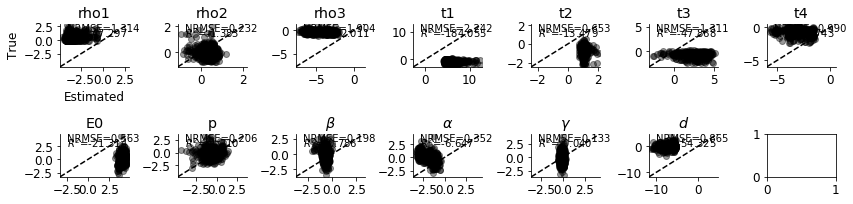

In [9]:
plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
                      n_samples_posterior, param_names, figsize=(12, 3))

## Manage checkpoints

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/SEIDR_learn_rho_E0/ckpt-15


## Checkpoint Model evaluation

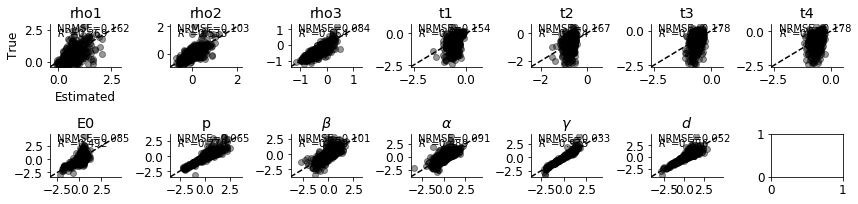

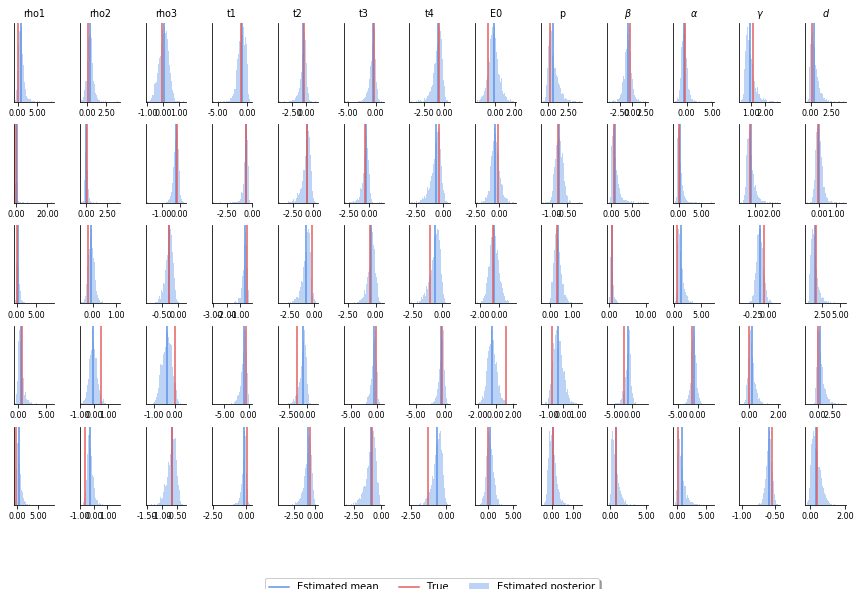

In [11]:
plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
              n_samples_posterior, param_names, figsize=(12, 3))

plot_true_est_posterior(model, 2000, param_names, font_size=8,
                X_test=test_data['x'][:5], 
                theta_test=test_data['theta'][:5], figsize=(12, 8))

# Train networks

In [12]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)

Instructions for updating:
Use tf.identity instead.


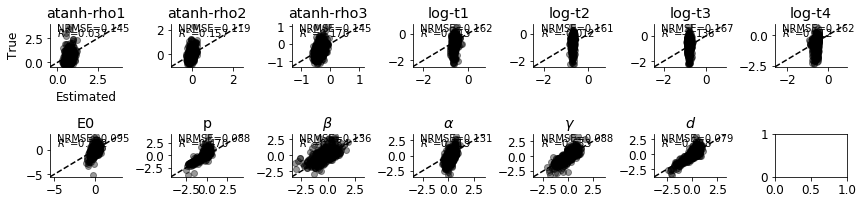

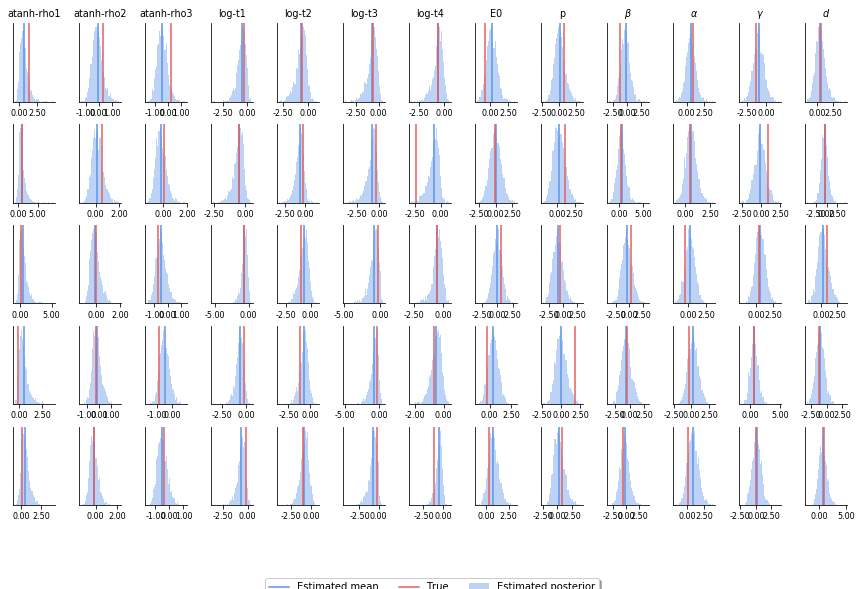

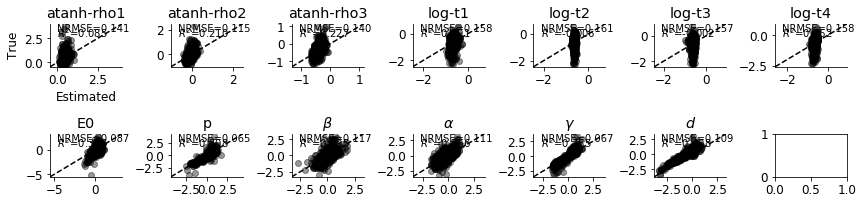

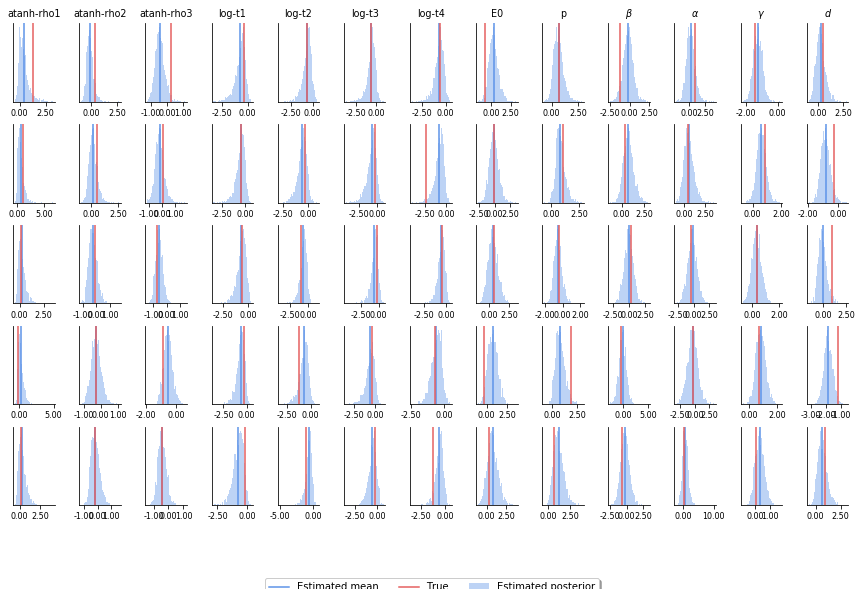

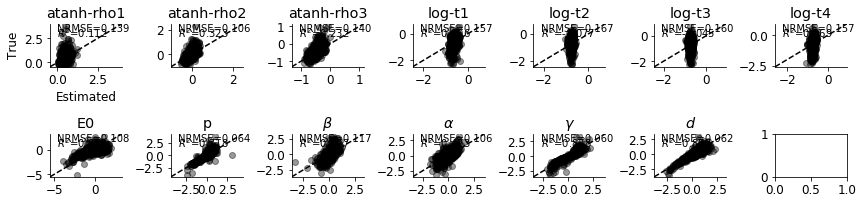

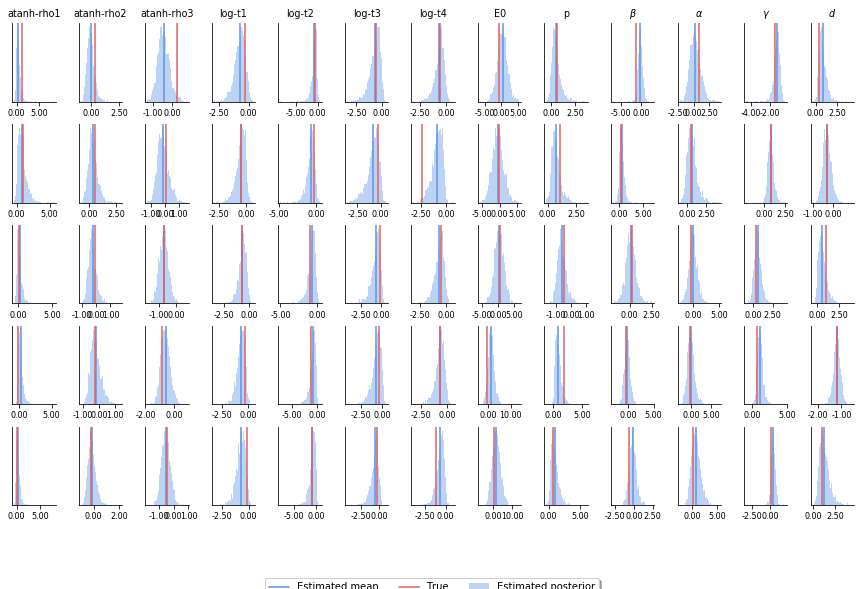

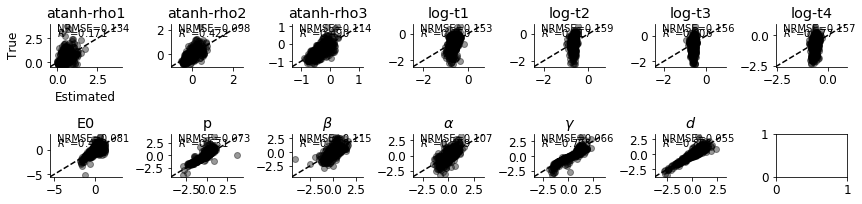

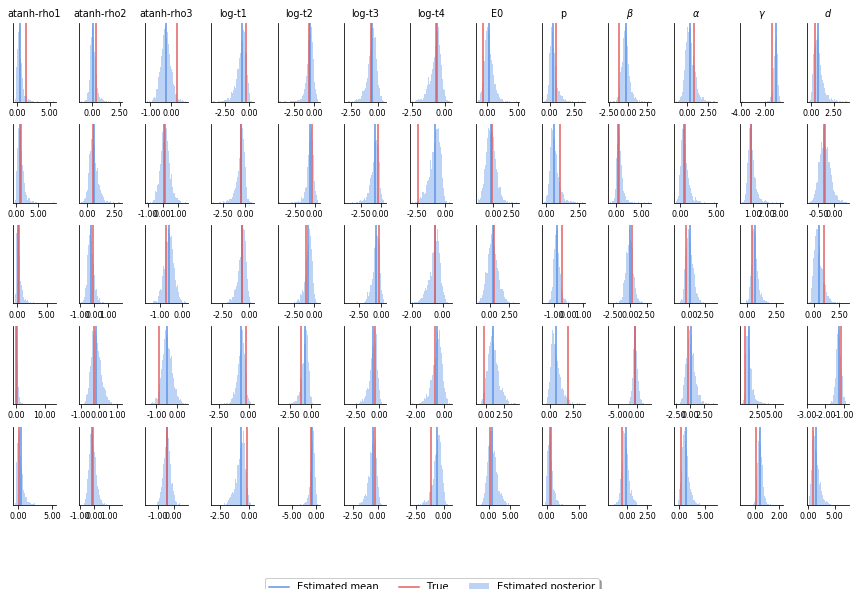

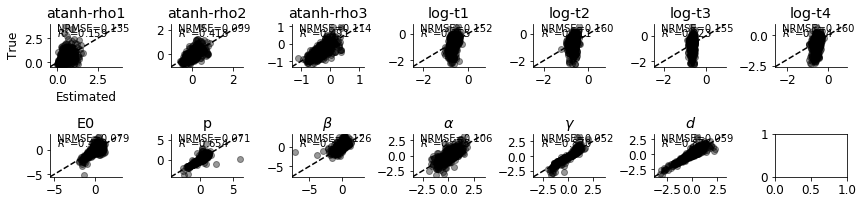

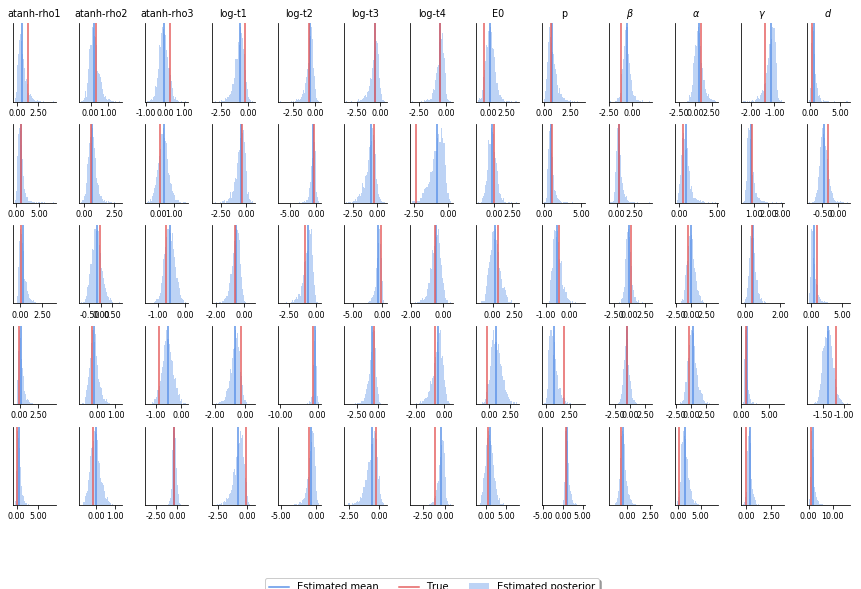

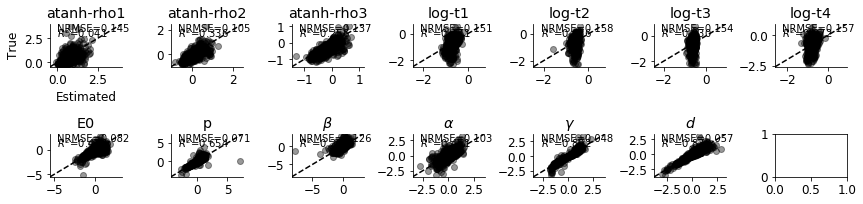

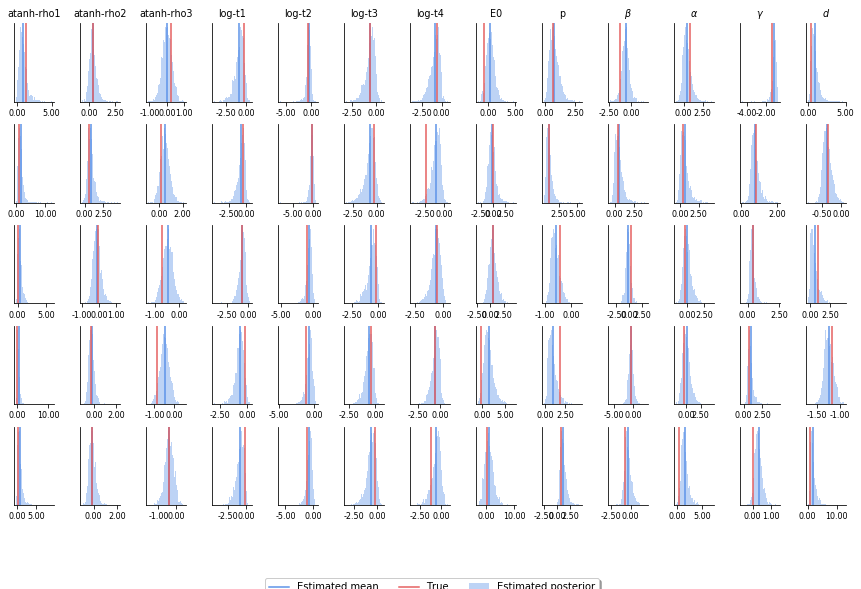

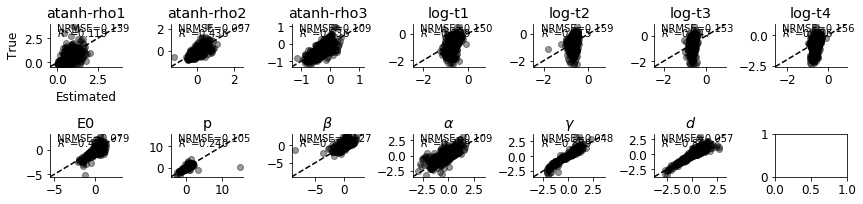

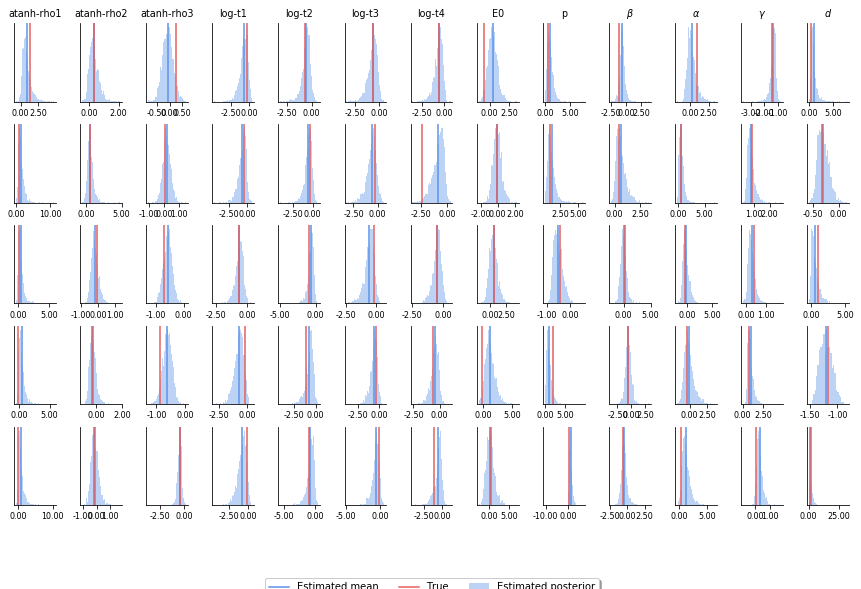

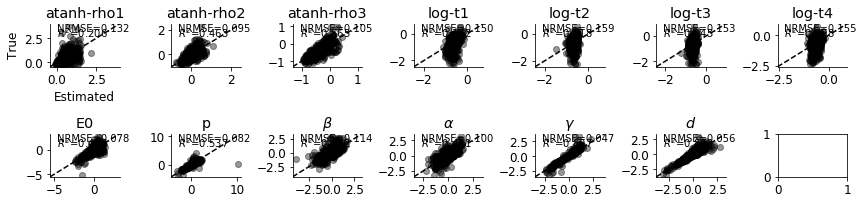

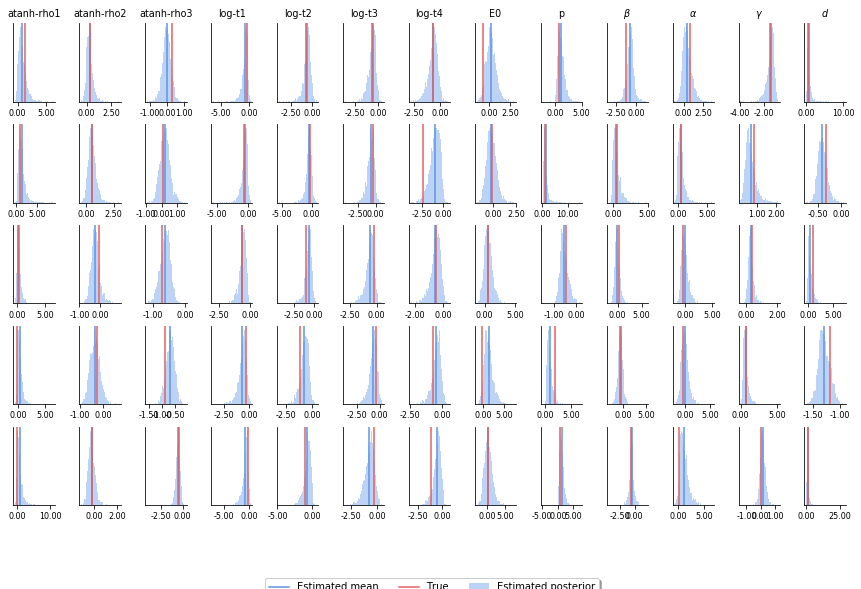

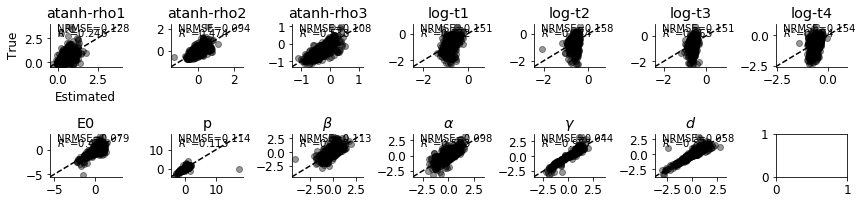

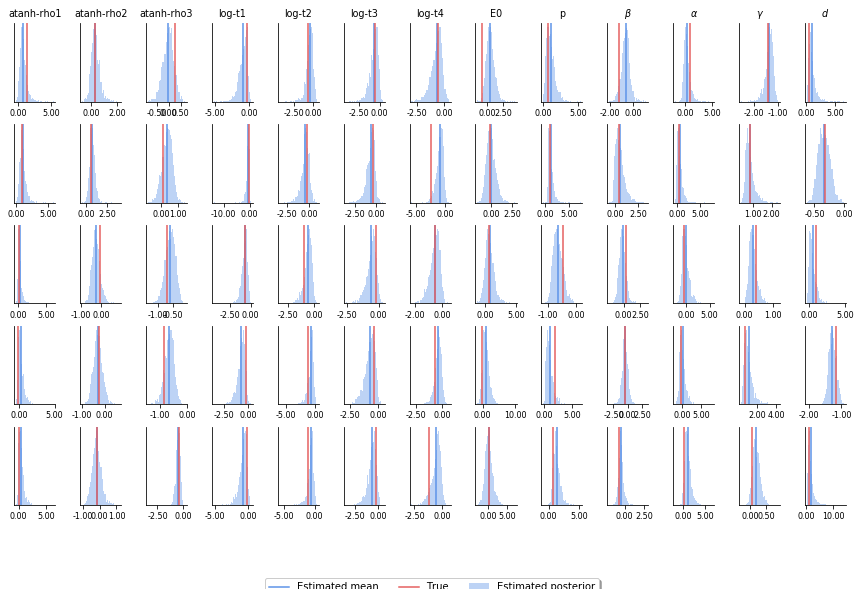

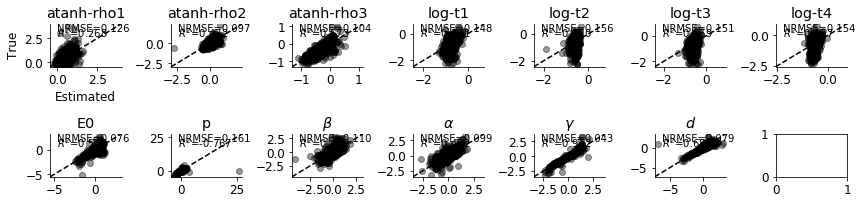

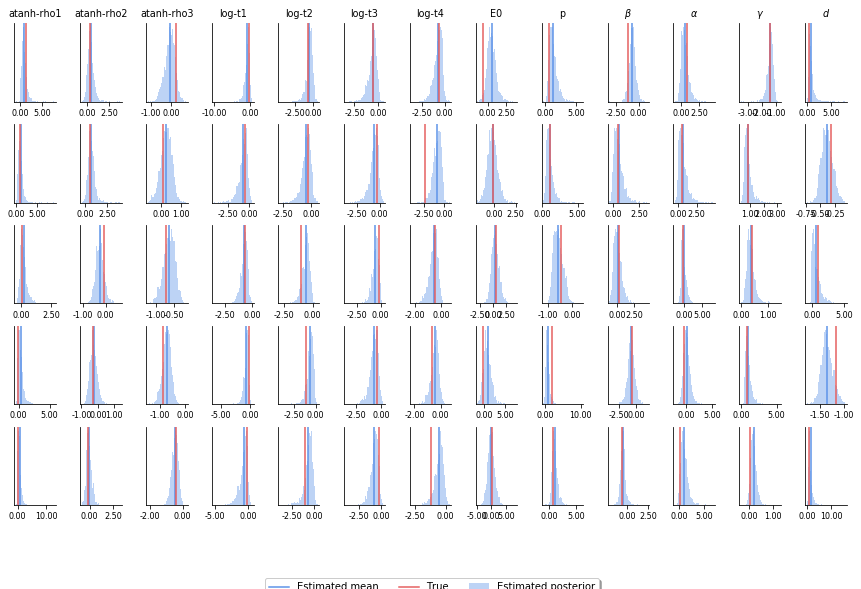

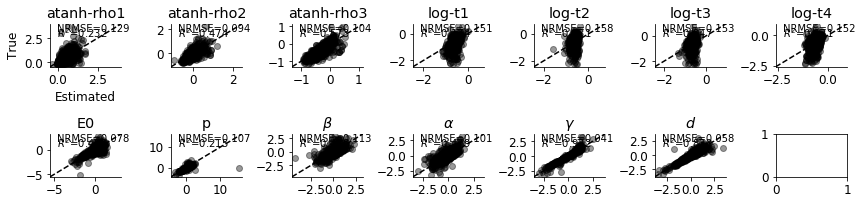

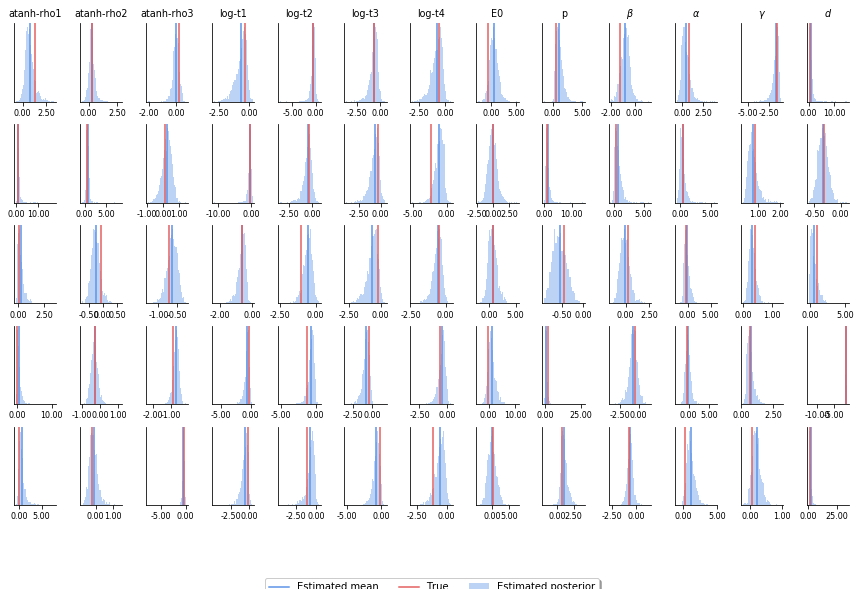

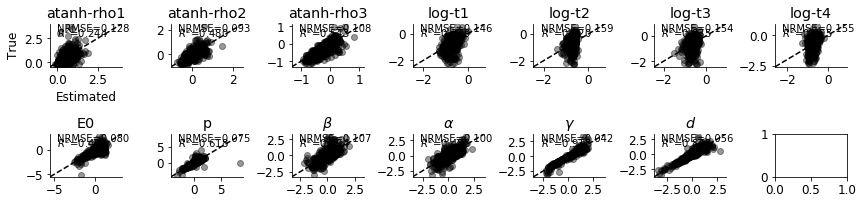

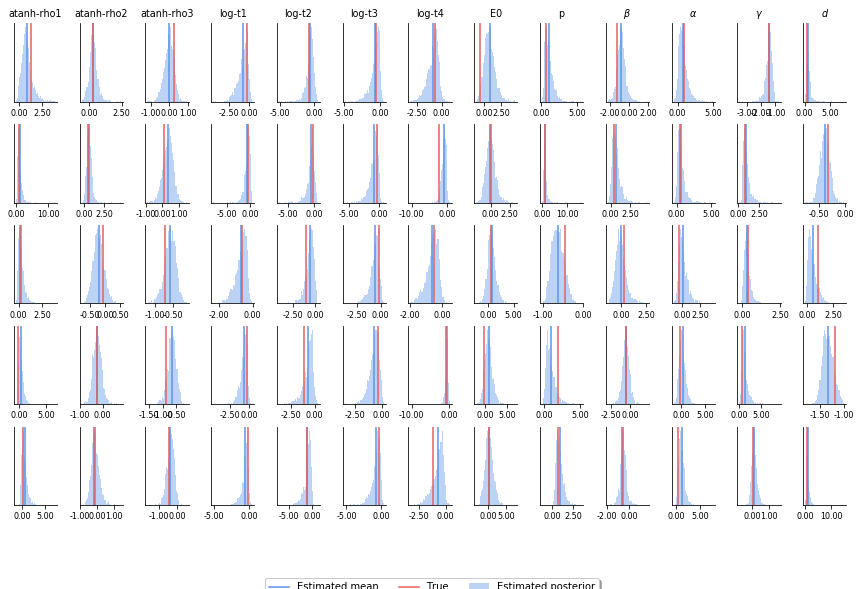

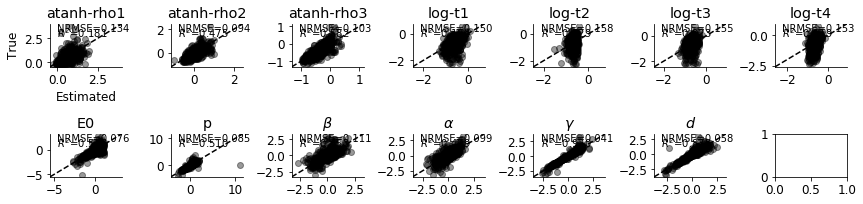

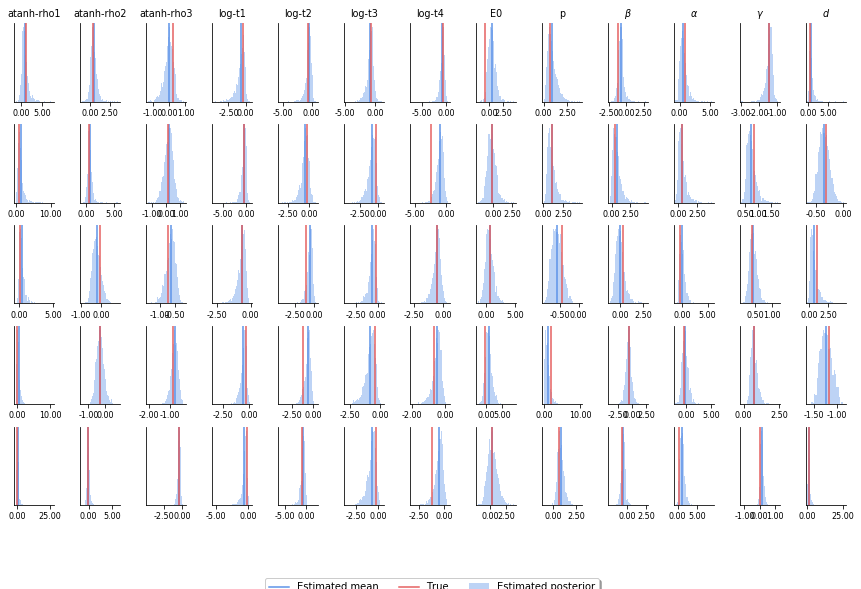

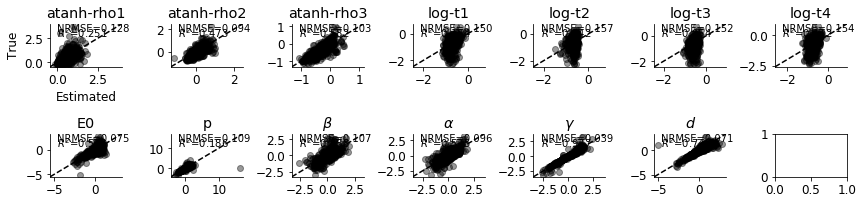

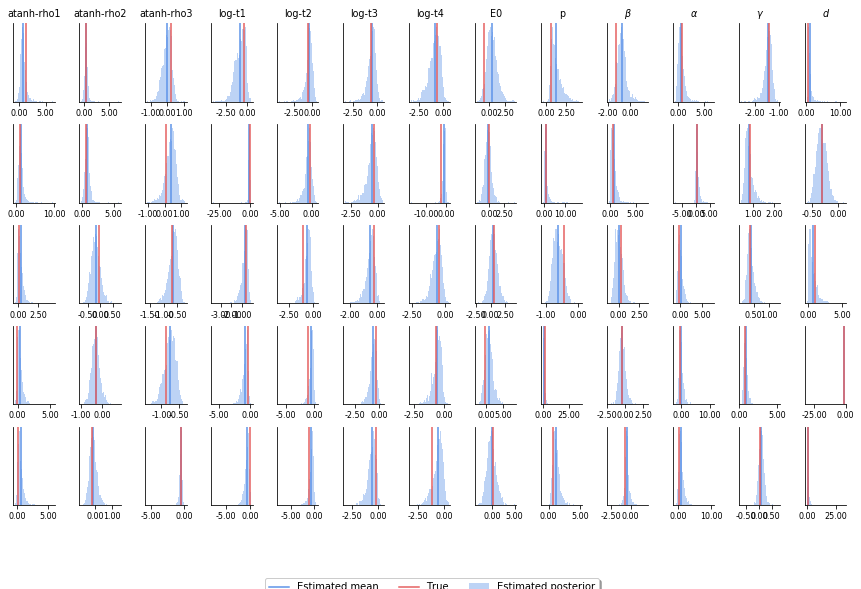

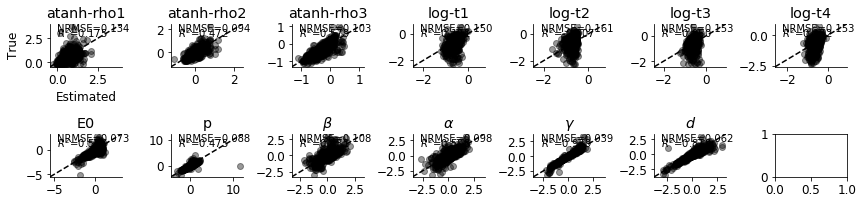

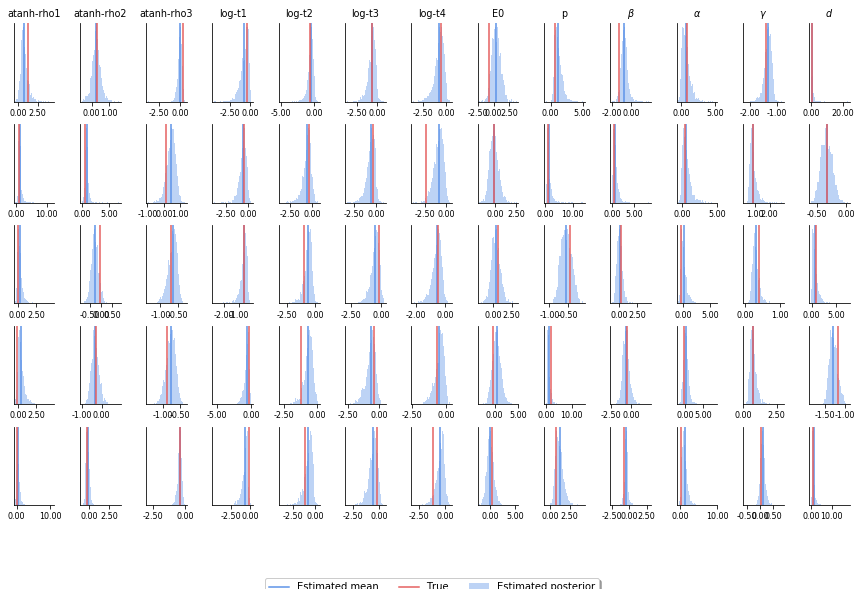

KeyboardInterrupt: 

In [13]:
%%time
for ep in range(1, epochs):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_generator, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='value',
                              global_step=global_step)
        
        plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
                      n_samples_posterior, param_names, figsize=(12, 3))
        
        plot_true_est_posterior(model, 2000, param_names, font_size=8,
                        X_test=test_data['x'][:5], 
                        theta_test=test_data['theta'][:5], figsize=(12, 8))

        # Manage checkpoint
        manager.save()

In [4]:
t_obs = 100
dt = 1    
t = np.linspace(0, t_obs, int(t_obs/dt) + 1)
params = np.array([1.2, 0.75, 0.2, 0.1, 0.6])
ts = forward_model(params, t=t)
labels = ['S', 'I', 'D', 'R']

f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(4):
    ax.plot(ts[:, i], label=labels[i], lw=2)

plt.legend()
ts_t = tf.convert_to_tensor(ts[np.newaxis], dtype=tf.float64)


theta_hat = model.sample(ts_t, 5000, to_numpy=True)

f, axarr = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    
    sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
    axarr[i].axvline(params[i], color='black')
    
f.tight_layout()

NameError: name 'np' is not defined

In [ ]:
t_obs = 30
dt = 1    
t = np.linspace(0, t_obs, int(t_obs/dt) + 1)
params = np.array([1.2, 0.75, 0.2, 0.1, 0.99])
ts = forward_model(params, t=t)
labels = ['S', 'I', 'D', 'R']

f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(4):
    ax.plot(ts[:, i], label=labels[i], lw=2)

plt.legend()
ts_t = tf.convert_to_tensor(ts[np.newaxis], dtype=tf.float64)


theta_hat = model.sample(ts_t, 5000, to_numpy=True)

f, axarr = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    
    sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
    axarr[i].axvline(params[i], color='black')
    
f.tight_layout()

In [ ]:
params

In [ ]:
theta_hat.mean(0)